In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.tsa.api as tsa
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import ndiffs

# Set wide fig size for plots
plt.rcParams['figure.figsize']=(12,3)


In [2]:
import pandas as pd


In [3]:
# Custom Functions
def plot_forecast(ts_train, ts_test, forecast_df, n_train_lags=None, 
                  figsize=(10,4), title='Comparing Forecast vs. True Data'):
    ### PLot training data, and forecast (with upper/,lower ci)
    fig, ax = plt.subplots(figsize=figsize)

    # setting the number of train lags to plot if not specified
    if n_train_lags==None:
        n_train_lags = len(ts_train)
            
    # Plotting Training  and test data
    ts_train.iloc[-n_train_lags:].plot(ax=ax, label="train")
    ts_test.plot(label="test", ax=ax)

    # Plot forecast
    forecast_df['mean'].plot(ax=ax, color='green', label="forecast")

    # Add the shaded confidence interval
    ax.fill_between(forecast_df.index, 
                    forecast_df['mean_ci_lower'],
                   forecast_df['mean_ci_upper'],
                   color='green', alpha=0.3,  lw=2)

    # set the title and add legend
    ax.set_title(title)
    ax.legend();
    
    return fig, ax



In [4]:
# Custom function for Ad Fuller Test
def get_adfuller_results(ts, alpha=.05, label='adfuller', **kwargs): #kwargs for adfuller()
    # Saving each output
    (test_stat, pval, nlags, nobs, crit_vals_d, 
    icbest ) = tsa.adfuller(ts, **kwargs)
    # Converting output to a dictionary with the interpretation of p
    adfuller_results = {'Test Statistic': test_stat,
                        "# of Lags Used":nlags, 
                       '# of Observations':nobs,
                        'p-value': round(pval,6),
                        'alpha': alpha,
                       'sig/stationary?': pval < alpha}
    return pd.DataFrame(adfuller_results, index =[label])



In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def regression_metrics_ts(ts_true, ts_pred, label="", verbose=True, output_dict=False,):
    # Get metrics
    mae = mean_absolute_error(ts_true, ts_pred)
    mse = mean_squared_error(ts_true, ts_pred)
    rmse = mean_squared_error(ts_true, ts_pred, squared=False)
    r_squared = r2_score(ts_true, ts_pred)
    mae_perc = mean_absolute_percentage_error(ts_true, ts_pred) * 100

    if verbose == True:
        # Print Result with label
        header = "---" * 20
        print(header, f"Regression Metrics: {label}", header, sep="\n")
        print(f"- MAE = {mae:,.3f}")
        print(f"- MSE = {mse:,.3f}")
        print(f"- RMSE = {rmse:,.3f}")
        print(f"- R^2 = {r_squared:,.3f}")
        print(f"- MAPE = {mae_perc:,.2f}%")

    if output_dict == True:
        metrics = {
            "Label": label,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r_squared,
            "MAPE(%)": mae_perc,
        }
        return metrics



In [6]:
def plot_acf_pacf(ts, nlags=40, figsize=(10, 5), 
                  annotate_sig=False, alpha=.05,
                 acf_kws={}, pacf_kws={},  
                  annotate_seas=False, m = None,
                 seas_color='black'):
    
    fig, axes = plt.subplots(nrows=2, figsize=figsize)

    
    # Sig lags line style
    sig_vline_kwargs = dict( ls=':', lw=1, zorder=0, color='red')

    # ACF
    tsa.graphics.plot_acf(ts, ax=axes[0], lags=nlags, **acf_kws)
    
    ## Annotating sig acf lags
    if annotate_sig == True:
        sig_acf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='ACF')
        for lag in sig_acf_lags:
            axes[0].axvline(lag,label='sig', **sig_vline_kwargs )

    # PACF
    tsa.graphics.plot_pacf(ts,ax=axes[1], lags=nlags, **pacf_kws)
    
    ## Annotating sig pacf lags
    if annotate_sig == True:
        ## ANNOTATING SIG LAGS
        sig_pacf_lags = get_sig_lags(ts,nlags=nlags,alpha=alpha, type='PACF')
        for lag in sig_pacf_lags:
            axes[1].axvline(lag, label='sig', **sig_vline_kwargs)



    
    ### ANNOTATE SEASONS
    if annotate_seas == True:
        # Ensure m was defined
        if m is None:
            raise Exception("Must define value of m if annotate_seas=True.")

        ## Calculate number of complete seasons to annotate
        n_seasons = nlags//m 

        # Seasonal Lines style
        seas_vline_kwargs = dict( ls='--',lw=1, alpha=.7, color=seas_color, zorder=-1)
        
        ## for each season, add a line
        for i in range(1, n_seasons+1):
            axes[0].axvline(m*i, **seas_vline_kwargs, label="season")
            axes[1].axvline(m*i, **seas_vline_kwargs, label="season")

    fig.tight_layout()
    
    return fig



In [7]:
df = pd.read_csv("Data/WMT.csv")
df.head()
                 

,Date,Adj Close
0,2000-01-03,44.915394
1,2000-01-04,43.234756
2,2000-01-05,42.352402
3,2000-01-06,42.814564
4,2000-01-07,46.049828


In [8]:
import datetime

fmt = "%Y-%m-%d"

df['Date'] = pd.to_datetime(df['Date'],format=fmt)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5479 entries, 0 to 5478
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5479 non-null   datetime64[ns]
 1   Adj Close  5284 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 85.7 KB


In [9]:
df = df.set_index('Date')
df.head(2)

,Adj Close
Date,
2000-01-03,44.915394
2000-01-04,43.234756


In [10]:
ts = df.asfreq('B')

In [11]:
ts = ts.loc['2010':'2020']
ts.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2870 entries, 2010-01-01 to 2020-12-31
Freq: B
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  2769 non-null   float64
dtypes: float64(1)
memory usage: 44.8 KB


In [12]:
ts.isna().sum()

Adj Close    101
dtype: int64

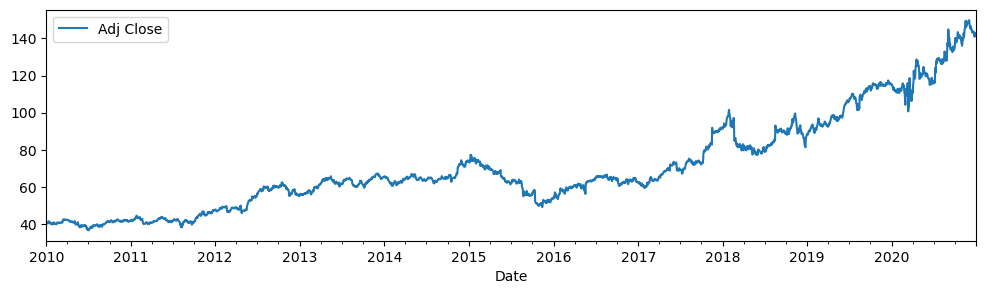

In [13]:
ts = ts.fillna(method='ffill')
ts.plot();

In [14]:
ts.isna().sum()

Adj Close    1
dtype: int64

In [15]:
ts = ts.dropna()

In [16]:
ts.isna().sum()

Adj Close    0
dtype: int64

In [17]:
get_adfuller_results(ts)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,1.436262,23,2845,0.997273,0.05,False


In [18]:
d = ndiffs(ts)
d

1

In [19]:
ts_diff = ts.diff().dropna()
get_adfuller_results(ts_diff)

,Test Statistic,# of Lags Used,# of Observations,p-value,alpha,sig/stationary?
adfuller,-12.215558,22,2845,0.0,0.05,True


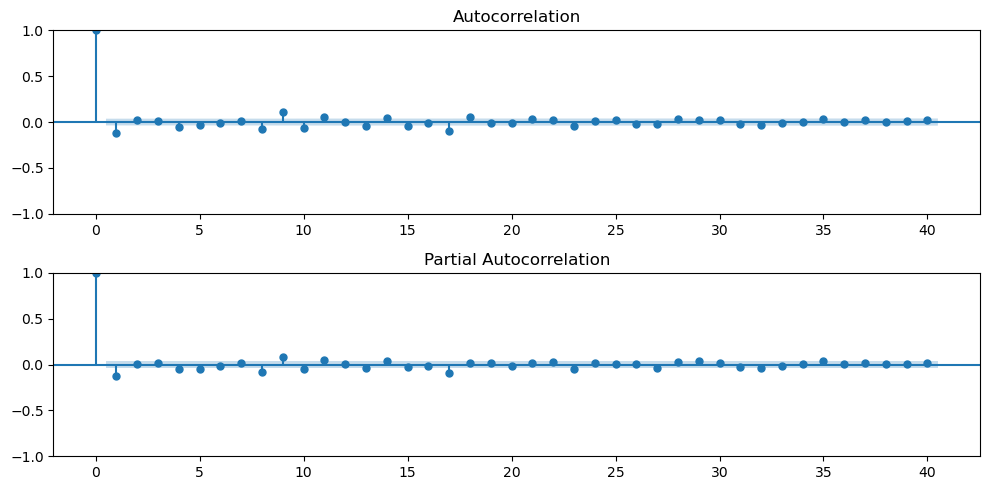

In [20]:
plot_acf_pacf(ts_diff);

# Interpretation of ACF/PACF 
- Gradual Drop off of ACF
- Gardual Drop off of PACF
- Differenced data once
- Start with (1,1,1)

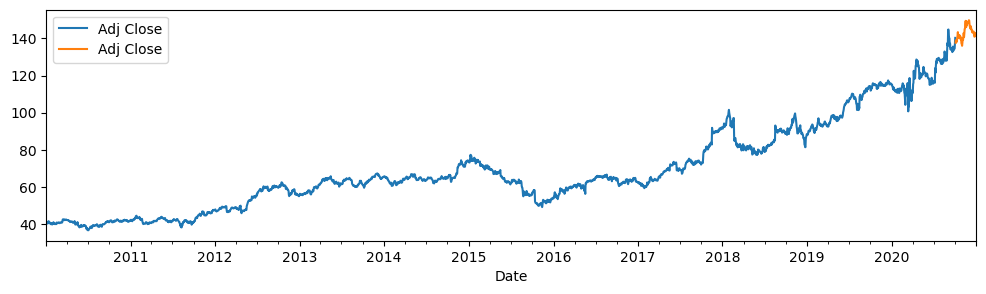

In [21]:
n_test_lags = 5*13
train, test = train_test_split(ts,test_size=n_test_lags)
ax = train.plot(label='Train')
test.plot(ax=ax, label='Test')
ax.legend();

In [22]:
p = 1
d = 1
q = 1

model = tsa.ARIMA(train, order=(p,d,q)).fit()
model

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 3.744
- MSE = 22.319
- RMSE = 4.724
- R^2 = -0.736
- MAPE = 2.57%


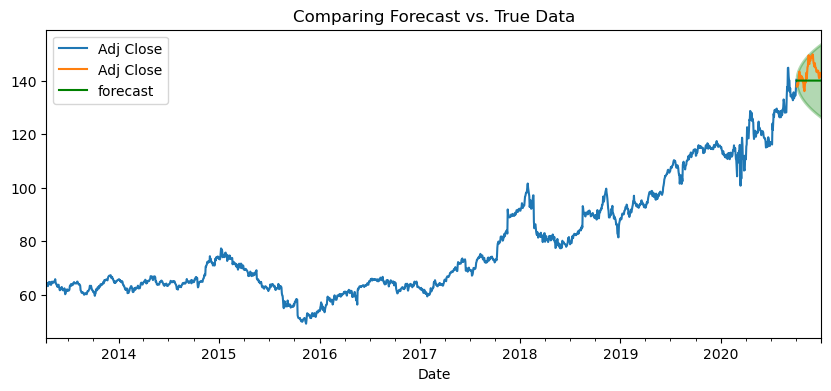

In [23]:
# Obtain summary of forecast as dataframe
forecast_df = model.get_forecast(len(test)).summary_frame()
#Plot the forecast with true values
plot_forecast(train, test, forecast_df,n_train_lags=1950)
#Obtain metrics
regression_metrics_ts(test,forecast_df['mean'])

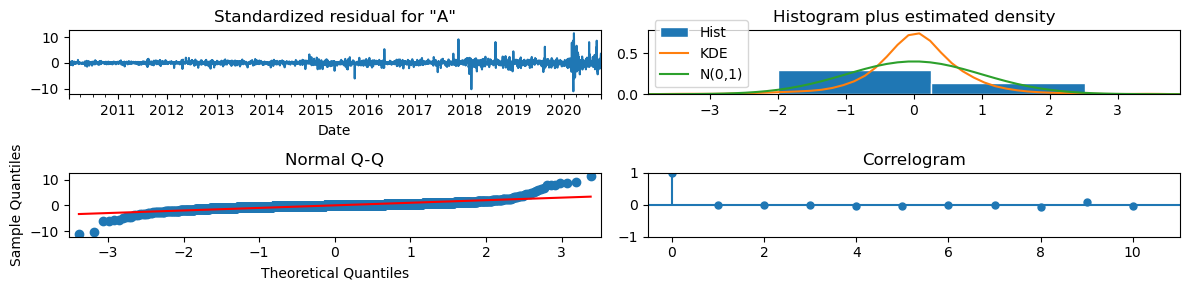

In [24]:
model.plot_diagnostics()
plt.tight_layout()

In [27]:
import itertools

# Define the value or range of values for p,d,q
p_values = range(0,4)
d_values = [1]
q_values = range(0,4)

#Create combinations of pdq to test 
pdq_to_try = list(itertools.product(p_values, d_values, q_values))

pdq_to_try

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 1, 0),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [29]:
# define starting aic as infinity
best_aic = float("inf")

#define basleine for pdq
best_pdq = (0,0,0)

#Loop through each combination
for pdq in pdq_to_try:
    model = tsa.ARIMA(train, order=pdq)
    result = model.fit()
    print(pdq, result.aic)

# If lower, replace best AIC with new value
    if result.aic < best_aic:
        best_aic = result.aic
        best_pdq = pdq
# Print the best orders and AIC score
print("Best AIC:", best_aic)
print("Best pdq:", best_pdq)

(0, 1, 0) 7817.4204384338
(0, 1, 1) 7780.48278476243
(0, 1, 2) 7781.152992998295
(0, 1, 3) 7782.8243105335605
(1, 1, 0) 7779.3218305888995
(1, 1, 1) 7781.14409791825
(1, 1, 2) 7781.943450849738
(1, 1, 3) 7778.23440648089
(2, 1, 0) 7781.127658164693
(2, 1, 1) 7783.302024788511


C:\Users\wkyle\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wkyle\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


(2, 1, 2) 7783.305214210703
(2, 1, 3) 7769.195764804712
(3, 1, 0) 7783.106545938992
(3, 1, 1) 7785.127596608317


C:\Users\wkyle\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\wkyle\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wkyle\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(3, 1, 2) 7772.342147207307
(3, 1, 3) 7771.189029226816
Best AIC: 7769.195764804712
Best pdq: (2, 1, 3)


C:\Users\wkyle\anaconda3\envs\dojo-env\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [30]:
# Build the model with the best AIC
p = 2 # AR component

d = 1 # Number of differencing required to make stationary

q = 3 # MA component

# Define and fit the model 
ar2model = tsa.ARIMA(train,order=(p,d,q)).fit()

------------------------------------------------------------
Regression Metrics: 
------------------------------------------------------------
- MAE = 4.144
- MSE = 26.204
- RMSE = 5.119
- R^2 = -1.038
- MAPE = 2.85%


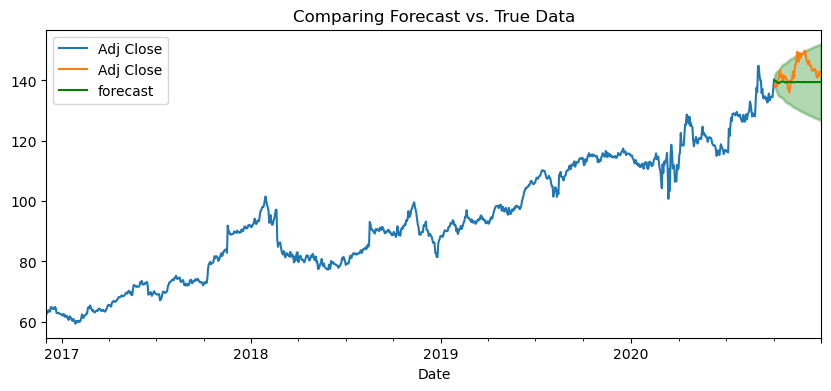

In [31]:
# Obtain summary of forecast as dataframe
forecast_df = ar2model.get_forecast(len(test)).summary_frame()
# Plot the forecast with true values
plot_forecast(train, test, forecast_df, n_train_lags = 1000)
#Obtain metrics
regression_metrics_ts(test,forecast_df['mean'])

- The MAPE for the intial model was 2.57 and for the second model was 2.85
- The AIC for the first model was 7781.14 and the second model was 7769.19
- The final model selected was ARIMA (1,1,1)